# Gravitational Wave Data Analysis:
---

## Part A: Data Acquisition
In this notebook we will use the gravitational wave data analysis toolkit called `PyCBC` to download, read and process real gravitational wave data. By the end we should be able to identify few real gravitational wave events by their event times.

In order to reach this goal we will need to learn how to handle data from the LIGO and Virgo observatories, including how to do the necessary data conditioning and matched filtering. 
Further, more technical reading on this topic can be found in [Abbott et al. (2020)](https://dx.doi.org/10.1088/1361-6382/ab685e)[[arXiv:1908.11170]](https://arxiv.org/abs/1908.11170).

This tutorial is inspired from Andrew Williamson's notebooks from the 2021 Nikhef GW workshop based on the [Gravitational Wave Open Data Workshop](https://github.com/gw-odw) and [`PyCBC` Tutorials](https://github.com/gwastro/PyCBC-Tutorials) repositories, taking code and inspiration heavily from both. 

If you're interested in learning more about GW signal detection and pre-processing, I recommend looking at the aforementioned resources for other extensive examples.

---

### 0. Install required software
- In this particular notebook, we will use `PyCBC`. Let us go ahead and install `PyCBC` and all its dependencies including `lalsuite` and `ligo-common`.
- You can do this (once) in your local machine with a working Python (3.7 and higher) installation or in a remote server using google colab.
- Ideally, use a virtual environment (`python venv` or `conda`) to install all necessary packages if you're using your local machine.

In [ ]:
## Check if pip matches your desired python installation/environment
! which pip

## Install pycbc and dependencies
! pip install pycbc lalsuite ligo-common

## Import packages
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import numpy as np
import pycbc

---

### 1. Download data from the Gravitational Wave Open Science Center (GWOSC)
- The Gravitational Wave Open Science Center (GWOSC – [gw-openscience.org](https://www.gw-openscience.org)) contains public resources and data from the gravitational wave detectors.

- Not all data is immediately made public but the data surrounding the time of all published detection candidates is made public at time of publication. Later, after a proprietory period, the data from entire observing runs are made available.

-> Let us download some data surrounding our first ever GW detection GW150914.


In [84]:
from pycbc import catalog

# Retreive an event's information (including data)
event_name = "GW150914" # https://gwosc.org/eventapi/html/GWTC-1-confident/GW150914/v3/
catalog_name = "gwtc-1" # refers to the first published GW transient catalog

merger = catalog.Merger(
                        name=event_name, 
                        source=catalog_name
                        )
## A good idea to check what attributes the merger object contains
print(f"GW event {merger.common_name} occured at GPS time {merger.time}.\n"
      f"It has binary component masses mass_1 = {merger.mass1}, and mass_2 = {merger.mass2}.\n"
      f"The merger event was {merger.distance} Mpc away (redshift = {merger.redshift}).\n"
      )
## The merger object also contains the data of the event

GW event GW150914 occured at GPS time 1126259462.4.
It has binary component masses mass_1 = 35.6, and mass_2 = 30.6.
The merger event was 440.0 Mpc away (redshift = 0.09).



-> Let us visualise the raw data of the merger

No V1 data available! Check if this is expected. Removing from our list.


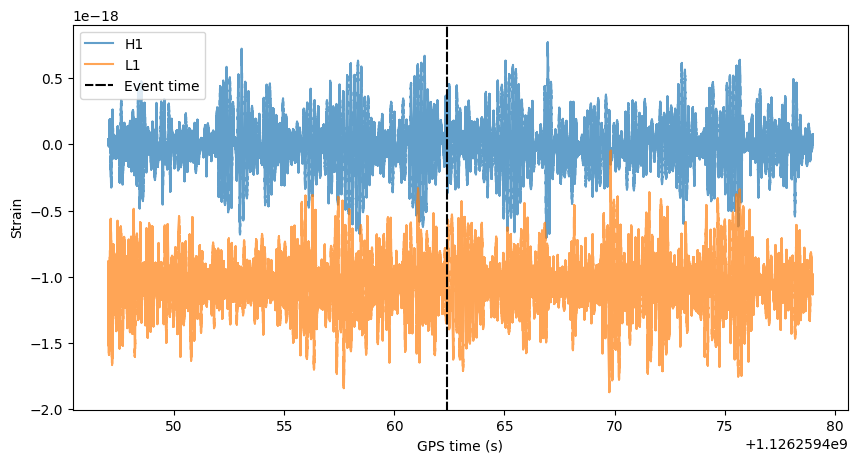

In [95]:
# Initialise figure (matplotlib)
fig = plt.figure(figsize=[10, 5])
ax = fig.gca()

# List the detectors we want to include
ifos = ['H1', 'L1', 'V1'] # hanford, livingston, virgo
for idx,ifo in enumerate(ifos):
    # Read in the data for each interferometer
    try:    
        ts = merger.strain(ifo)
        ax.plot(ts.sample_times, ts, label=ifo, alpha=0.7, color=colors[idx])
    except:
        print(f"No {ifo} data available! Check if this is expected. "
              "Removing from our list.")
        ifos.remove(ifo)

ax.axvline(merger.time, color="black", linestyle=(1,(5,1)), label="Event time")
ax.set_ylabel('Strain')
ax.set_xlabel('GPS time (s)')
ax.legend(loc='upper left');

-> Note the scale of the y-axis. Gravitational wave signals observed by our observatories typically have peak strains of $\mathcal{O}(10^{-21})$ or less!

**In gravitational wave detector data signals are buried in noise.** 

This is why we need to do some data conditioning/filtering to find and characterise them.

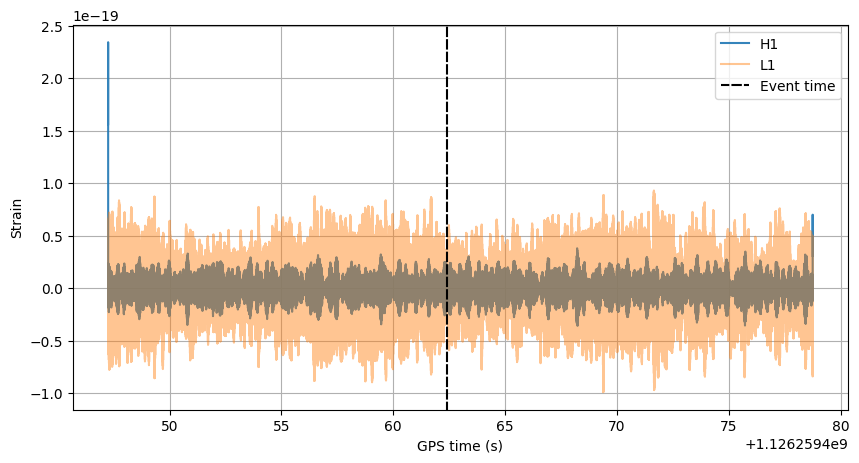

In [109]:
from pycbc import psd
import pycbc.filter as filter
# Set up dictionary for storing output
data = {}

# Initialise figure
fig = plt.figure(figsize=[10, 5])
ax = plt.gca()

# Define our low frequency cut off
f_low = 20.0
for idx,ifo in enumerate(ifos):
    # Read in the data for each interferometer, this time using a finite impulse
    # response filter to remove high & low frequencies outside the signal range
    ts = merger.strain(ifo).highpass_fir(20, 1024)
    data[ifo] = filter.resample_to_delta_t(ts, 1.0/2048)
    ax.plot(data[ifo].sample_times, data[ifo], label=ifo, alpha=0.9/(1+idx))

ax.axvline(merger.time, color="black", linestyle=(1,(5,1)), label="Event time")
ax.set_ylabel('Strain')
ax.set_xlabel('GPS time (s)')
ax.grid()
ax.legend()